In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('data.csv', encoding='utf-8')###读取文件

In [3]:
###预处理
data.dropna(inplace=True)
###转换格式
###转换日期
month_dict = {
    '1月': 'January', '2月': 'February', '3月': 'March',
    '4月': 'April', '5月': 'May', '6月': 'June',
    '7月': 'July', '8月': 'August', '9月': 'September',
    '10月': 'October', '11月': 'November', '12月': 'December'
}
def convert_to_english_date(chinese_date_str):
    month_chinese = chinese_date_str.split('月')[0] + '月'
    year = chinese_date_str.split('月')[1]
    month_english = month_dict.get(month_chinese, 'Unknown')
    return f"{month_english} {year}"

data['Year Month'] = data['Year Month'].apply(convert_to_english_date)
data['Year Month'] = pd.to_datetime(data['Year Month'], errors='coerce')
data.rename(columns={'Year Month': 'Date'}, inplace=True)
data.sort_values(by='Date', inplace=True)

In [4]:
###转换年龄
def classify_age_group(age_group):
    if age_group in ['0-4', '5-9', '10-14', '15-19']:
        return 'Teenagers'
    elif age_group in ['20-24', '25-29', '30-34', '35-39']:
        return 'Middle-aged-young'
    elif age_group in ['40-44', '45-49', '50-54', '55-59']:
        return 'Middle-aged-old'
    elif age_group in ['60-64', '65-69', '70-74', '75-79', '80yearsorover']:
        return 'Elderly'
    else:
        return 'Unknown'
data['Age Group'] = data['Age Group'].apply(classify_age_group)

In [5]:
###检查Victimisations
#data['Victimisations'] = pd.to_numeric(data['Victimisations'], errors='coerce')
#if data['Victimisations'].isna().sum() == 0:
 #   print("The column is all numbers.")
   # min_value = data['Victimisations'].min()
  #  max_value = data['Victimisations'].max()
    #print(f"the range is from {min_value} to {max_value}")

#else:
 #   print("invalid")


In [6]:
#data.to_csv('clean_data.csv', index=False)

In [7]:
#sns.countplot(data=data, x='Age Group')
#plt.show()

In [8]:
#ethnic_group_counts = data['Ethnic Group'].value_counts()
#plt.figure(figsize=(10, 7))
#plt.pie(ethnic_group_counts, labels=ethnic_group_counts.index, autopct='%1.1f%%', startangle=90)
#plt.axis('equal')
#plt.title('Distribution of Ethnic Groups')
#plt.show()

In [9]:
#sns.countplot(data=data, y='ANZSOC Division')
#plt.show()

In [10]:
#data.groupby('Date')['Victimisations'].sum().plot()
#plt.xlabel('Date')
#plt.ylabel('Total Victimisations')
#plt.show()

In [11]:
data.head()

,Date,Victimisations,Police District,Police Area,Person/Organisation,Ethnic Group,Age Group,ANZSOC Division
1179503,2015-05-01,1,Southern,Otago Coastal Area,Person,European,Middle-aged-young,Theft and Related Offences
1180898,2015-05-01,1,Auckland City,Auckland East Area,Person,Pacific Island,Teenagers,Acts Intended to Cause Injury
1180897,2015-05-01,1,Counties/Manukau,Counties Manukau Central Area,Person,Other Ethnicities,Middle-aged-young,Acts Intended to Cause Injury
1180896,2015-05-01,1,Southern,Otago Coastal Area,Person,Not Stated,Teenagers,Acts Intended to Cause Injury
1180895,2015-05-01,1,Northland,Whangarei Area,Person,Not Stated,Teenagers,Acts Intended to Cause Injury


In [12]:
grouped_data = data.groupby("Date")["Victimisations"].sum().reset_index()

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [14]:
train_data = grouped_data[grouped_data['Date'] < '2021-01-01']
test_data = grouped_data[grouped_data['Date'] >= '2021-01-01']

In [15]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['Victimisations']])
test_scaled = scaler.transform(test_data[['Victimisations']])

In [16]:
def create_dataset(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

window_size = 3
X_train, y_train = create_dataset(train_scaled, window_size)
X_test, y_test = create_dataset(test_scaled, window_size)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [17]:
model = Sequential()
model.add(LSTM(200, input_shape=(window_size, 1)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=30)

history = model.fit(X_train, y_train, epochs=100, batch_size=3,
                    callbacks=[early_stop])


Epoch 1/100
22/22 [==============================] - 2s 3ms/step - loss: 0.1413
Epoch 2/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0249
Epoch 3/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0232
Epoch 4/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 5/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0213
Epoch 6/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 7/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 8/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0226
Epoch 9/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 10/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0223
Epoch 11/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0214
Epoch 12/100
22/22 [==============================] - 0s 3ms/step - loss: 0.0209
Epoch 13/100
22/22 [=================

In [18]:
predicted = model.predict(X_test)
predicted_transformed = scaler.inverse_transform(np.reshape(predicted, (-1, 1)))
y_test_transformed = scaler.inverse_transform(np.reshape(y_test, (-1, 1)))


1/1 [==============================] - 0s 391ms/step


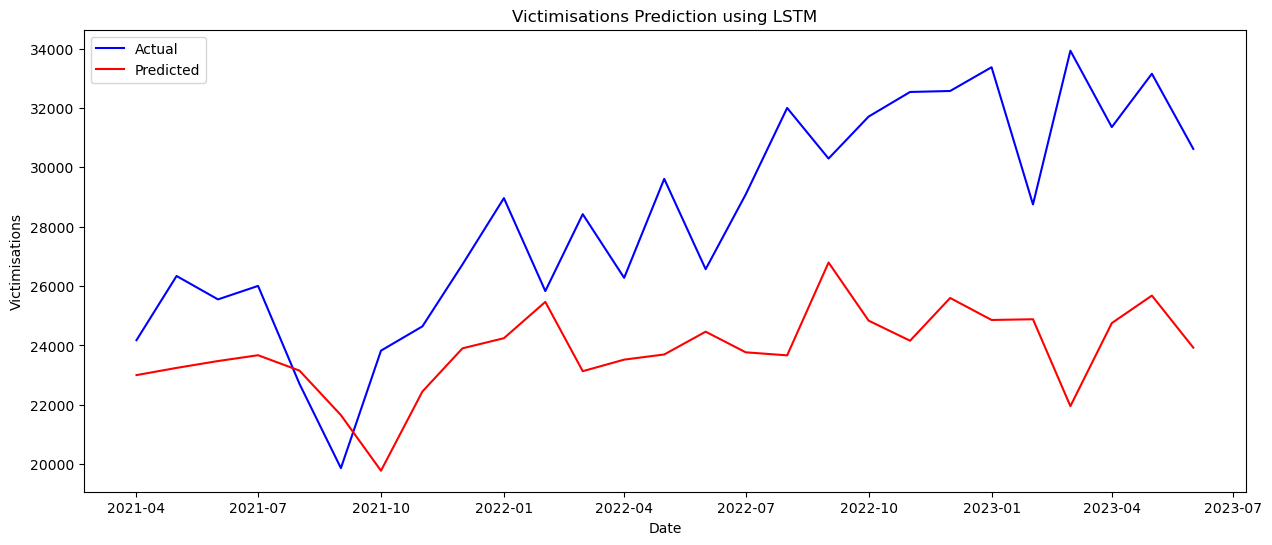

In [19]:
time_axis = test_data['Date'][window_size:]
plt.figure(figsize=(15, 6))
plt.plot(time_axis, y_test_transformed, label='Actual', color='blue')
plt.plot(time_axis, predicted_transformed, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.title('Victimisations Prediction using LSTM')
plt.legend()
plt.show()

In [20]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

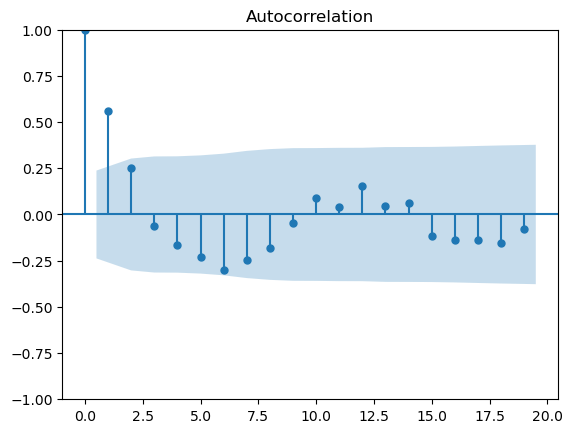

D:\Anaconda\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


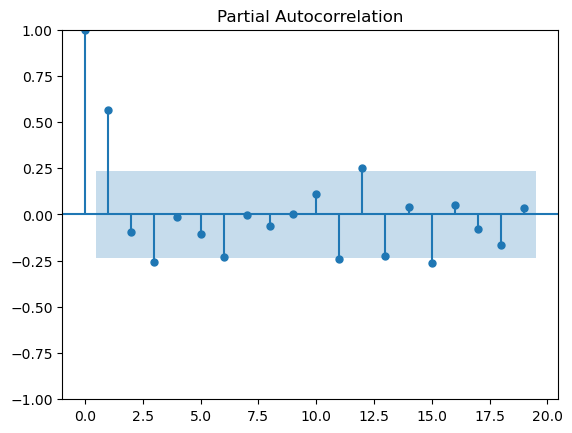

In [21]:
plot_acf(train_data['Victimisations'])
plt.show()
plot_pacf(train_data['Victimisations'])
plt.show()

In [22]:
model = ARIMA(train_data['Victimisations'], order=(2,2,2))
model_fit = model.fit()

D:\Anaconda\Lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
print(model_fit.summary())
predictions = model_fit.forecast(steps=len(test_data))

                               SARIMAX Results                                
Dep. Variable:         Victimisations   No. Observations:                   68
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -606.027
Date:                Sun, 10 Sep 2023   AIC                           1222.054
Time:                        11:33:59   BIC                           1233.002
Sample:                             0   HQIC                          1226.380
                                 - 68                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7163      0.002   -434.739      0.000      -0.720      -0.713
ar.L2          0.2837      0.002    152.228      0.000       0.280       0.287
ma.L1         -0.0001      0.000     -0.364      0.7

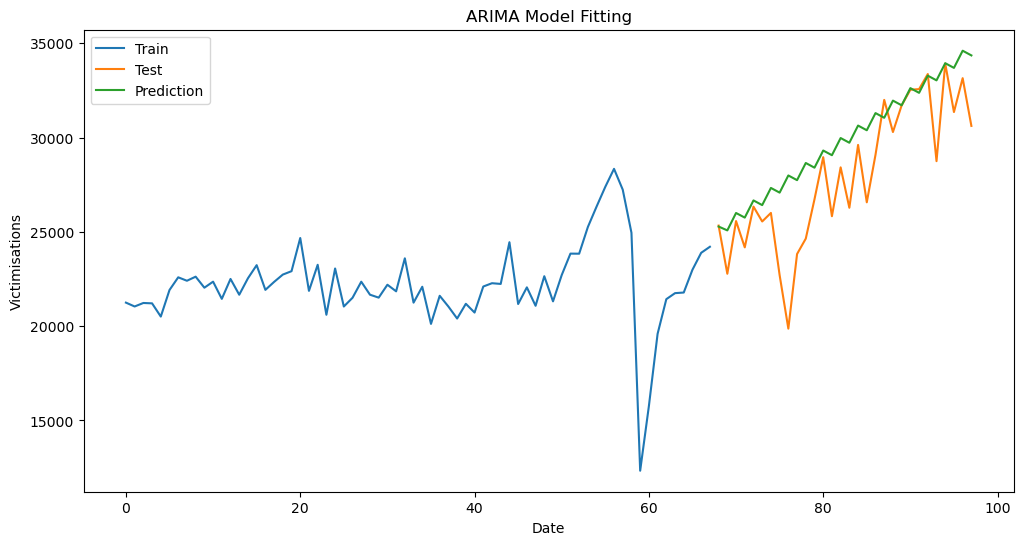

In [24]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data['Victimisations'], label='Train')
plt.plot(test_data.index, test_data['Victimisations'], label='Test')
plt.plot(test_data.index, predictions, label='Prediction')
plt.title("ARIMA Model Fitting")
plt.xlabel("Date")
plt.ylabel("Victimisations")
plt.legend()
plt.show()

In [25]:
residuals = model_fit.resid
model_nn = Sequential()
model_nn.add(Dense(200, input_dim=1, activation='swish'))
model_nn.add(Dropout(0.2))
model_nn.add(Dense(1, activation='linear'))
model_nn.compile(loss='mean_squared_error', optimizer='adam')
model_nn.fit(residuals[:-1], residuals[1:], epochs=100, batch_size=5)

Epoch 1/100
14/14 [==============================] - 0s 1ms/step - loss: 7665437.5000
Epoch 2/100
14/14 [==============================] - 0s 986us/step - loss: 7529182.0000
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 6427610.0000
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 6574217.5000
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 5841700.0000
Epoch 6/100
14/14 [==============================] - 0s 944us/step - loss: 5740696.5000
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 6137323.0000
Epoch 8/100
14/14 [==============================] - 0s 1ms/step - loss: 5611130.5000
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 5756424.0000
Epoch 10/100
14/14 [==============================] - 0s 952us/step - loss: 6033050.0000
Epoch 11/100
14/14 [==============================] - 0s 962us/step - loss: 5694210.0000
Epoch 12/100
14/14 [========================

In [26]:
arima_predictions = model_fit.forecast(steps=len(test_data))
nn_predictions = model_nn.predict(residuals[-len(test_data):])
final_predictions = arima_predictions + nn_predictions.flatten()

1/1 [==============================] - 0s 60ms/step


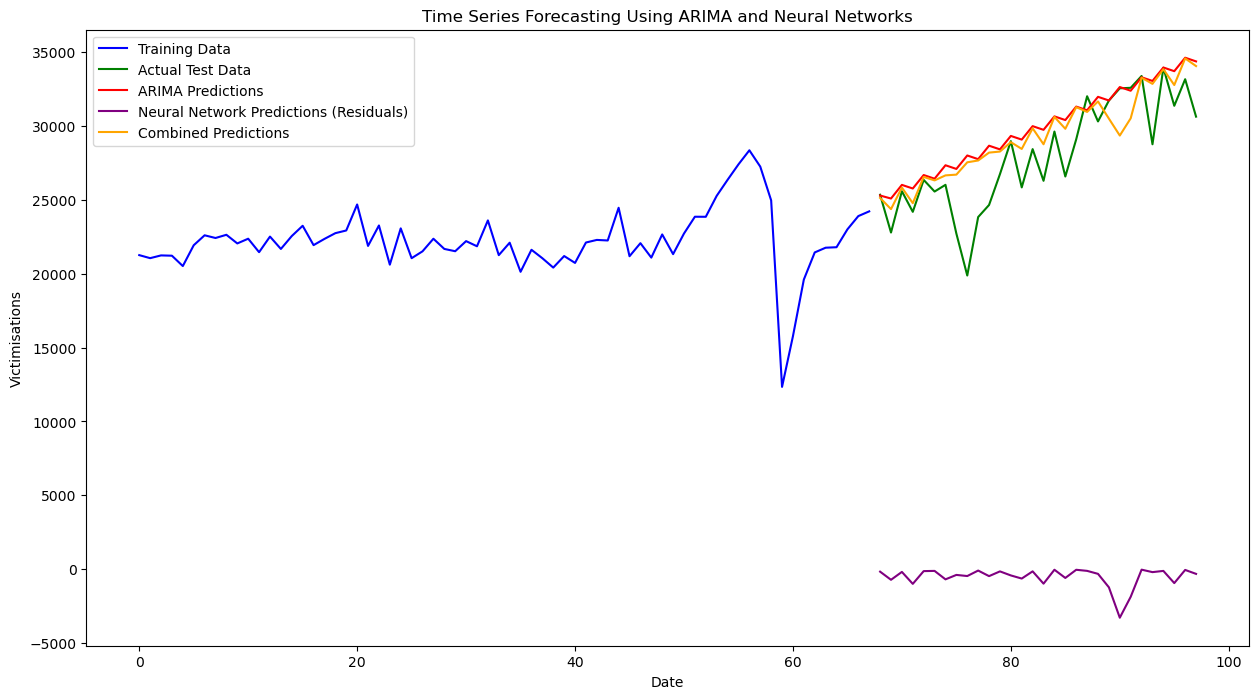

In [27]:
plt.figure(figsize=(15,8))
plt.plot(train_data.index, train_data['Victimisations'], label='Training Data', color='blue')
plt.plot(test_data.index, test_data['Victimisations'], label='Actual Test Data', color='green')
plt.plot(test_data.index, arima_predictions, label='ARIMA Predictions', color='red')
plt.plot(test_data.index, nn_predictions.flatten(), label='Neural Network Predictions (Residuals)', color='purple')
plt.plot(test_data.index, final_predictions, label='Combined Predictions', color='orange')
plt.legend()
plt.title('Time Series Forecasting Using ARIMA and Neural Networks')
plt.xlabel('Date')
plt.ylabel('Victimisations')
plt.show()

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
min_length = min(len(predictions), len(predicted_transformed))
predictions = predictions[:min_length]
predicted_transformed = predicted_transformed[:min_length]

stacked_predictions = np.column_stack((predictions, predicted_transformed))
linreg = LinearRegression()
linreg.fit(stacked_predictions, y_test_transformed)
final_predictions = linreg.predict(stacked_predictions)

mse = mean_squared_error(y_test_transformed, final_predictions)
print(f"Final MSE: {mse}")

Final MSE: 4149543.592962664


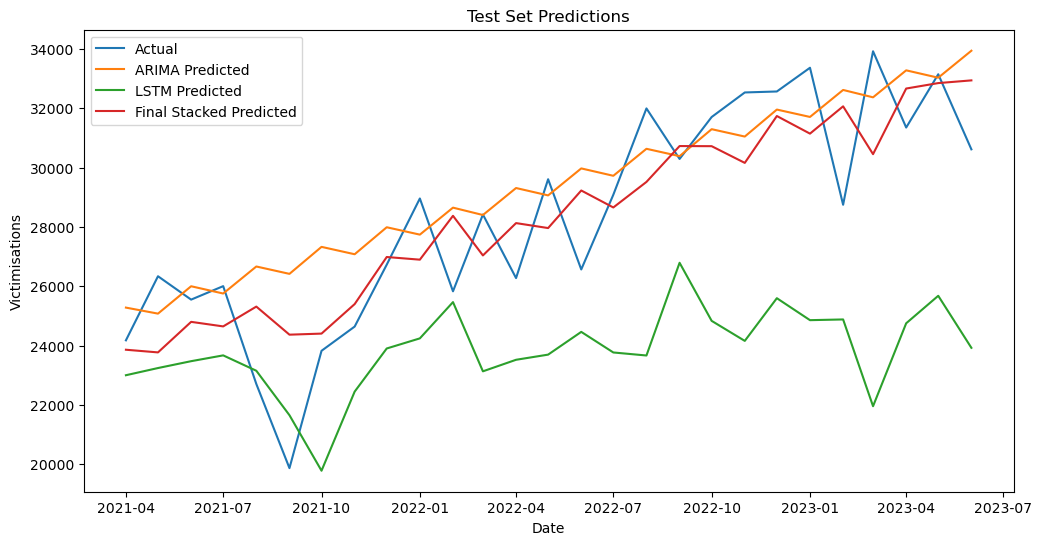

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(time_axis, y_test_transformed, label='Actual')
plt.plot(time_axis, predictions, label='ARIMA Predicted')
plt.plot(time_axis, predicted_transformed, label='LSTM Predicted')
plt.plot(time_axis, final_predictions, label='Final Stacked Predicted')
plt.legend()
plt.title("Test Set Predictions")
plt.xlabel("Date")
plt.ylabel("Victimisations")
plt.show()